# Introduction
The following examples show how to use the **intand** (**INT**eractive **AN**omaly **D**etection) to detect anomalies in a dataset by repeatedly interacting with a human expert and incorporating his feedback.

Installation:

```
$ git clone XXX
$ cd interactive-anomaly-detection
$ pip install .
```

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path
sys.path.append('/Users/chenglingyun/Desktop/interactive-anomaly-detection/examples')
from intand import datasets, Evaluation, feedback_loop
from intand.ensembles import IsoForest
from intand.models import Unsupervised, OJRank, OMD, AAD

import intand
print("VERSION:", intand.__version__)


VERSION: 0.1.0


# 1. Loading a dataset and computing anomaly scores
Several anomaly detection datasets (with labels for evaluation) are integrated into the **intand** library. The following code shows how to load a dataset: $X \in \mathbb{R^{n \times d}}$ (with $n$ samples and $d$ features) and the corresponding labels $y \in \mathbb{\{-1, 1\}^n}$. Then it computes the initial anomay scores $Z \in \mathbb{R^{n \times m}}$ using an unsupervised ensemble method (of $m$ anomaly detectors) such as Isolation Forest.

In [21]:
X, y = datasets.load_dataset('toy2', normalize=True)
Z = IsoForest(n_trees=20).fit(X).transform(X)

In [31]:
Z

array([[0.4201271 , 0.47433282, 0.39871146, ..., 0.30758037, 0.42360142,
        0.42733365],
       [0.54393383, 0.53635471, 0.62274982, ..., 0.54393383, 0.66634229,
        0.47433282],
       [0.39659764, 0.45818666, 0.53635471, ..., 0.30758037, 0.47433282,
        0.3767251 ],
       ...,
       [0.40824941, 0.71298624, 0.71298624, ..., 0.30758037, 0.53635471,
        0.62274982],
       [0.4972253 , 0.62274982, 0.53635471, ..., 0.54393383, 0.76289526,
        0.48461688],
       [0.4972253 , 0.41687897, 0.39457443, ..., 0.30758037, 0.47433282,
        0.38244257]])

In [22]:
X.shape

(485, 2)

In [12]:
y.shape

(485,)

The first argument of `datasets.load_dataset(...)` corresponds to the name of the dataset. The following datasets are available in the library: `'abalone', 'ann_thyroid_1v3', 'cardiotocography', 'covtype', 'covtype_sub', 'electricity', 'kddcup', 'kddcup_sub', 'mammography', 'mammography_sub', 'shuttle', 'shuttle_sub', 'toy', 'toy2', 'toy_hard', 'weather', 'yeast'`.

# 2. Using an interactive anomaly detection model
Several models are available: OJRank, OMD, AAD, and IADE. The following model shows how to instanciate a model and use it inside a feedback loop to integrate the expert feedback (binary label -1 = nominal, 1 = anomaly).

Total: 1 (0 anomalies, 1 nominals)

<IPython.core.display.Javascript object>


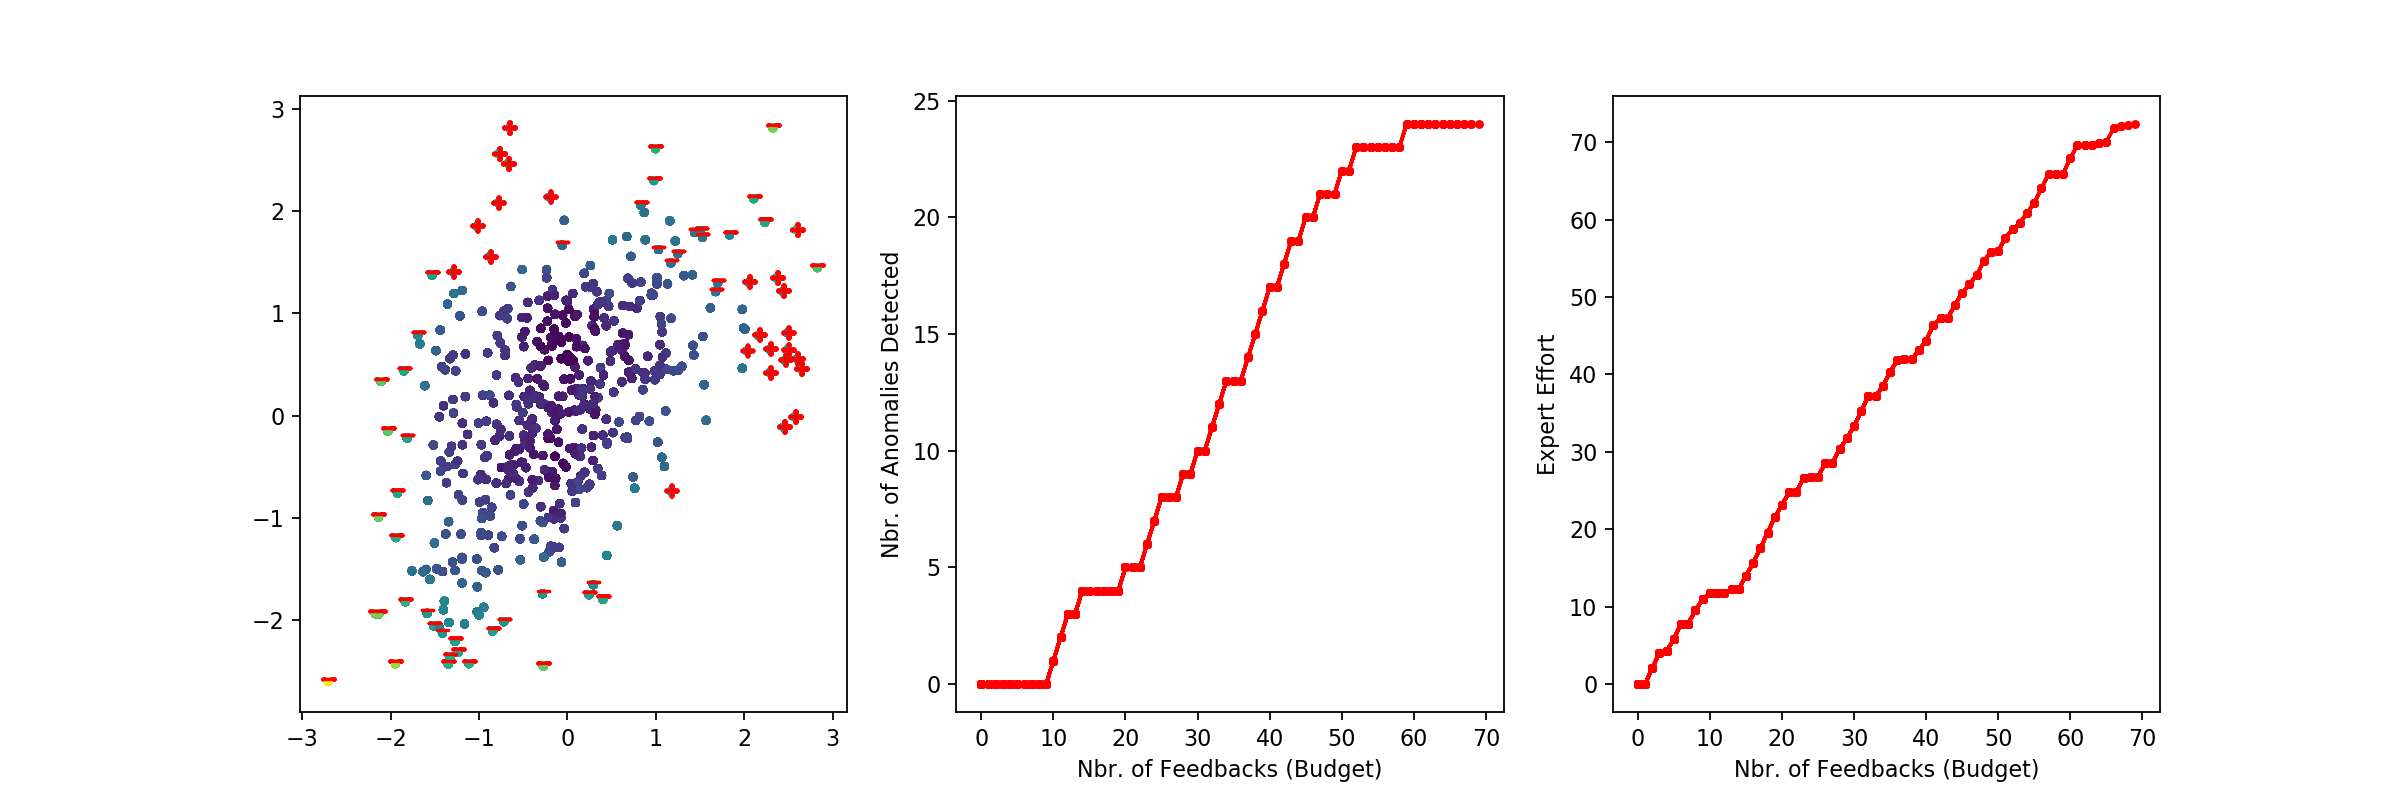

Total: 70 (24 anomalies, 46 nominals)

In [7]:
model = OMD(Z, X, plot=True)  # Instanciating a model (set plot to False if you don't want visualization)

budget = 70
for itr in range(budget):
    i = model.get_top1()  # get the index of the most anomalous instance
    feedback = y[i]       # present the selected instance to an expert and get a feedback
    model.update(i, feedback)  # update the model based on the feedback


In the above code, the user feedback was simulated with labels that are taken from the array $y$. However, depending on your application, this feedback can be obtained from a real expert at each iteration (e.g. through a GUI or a web interface etc).

If you have labels $y$ already available and you want to use them to simulate an expert (for testing or evaluation purposes), then you can directly use the `feedback_loop(...)` function as follows.

Total: 1 (0 anomalies, 1 nominals)

<IPython.core.display.Javascript object>


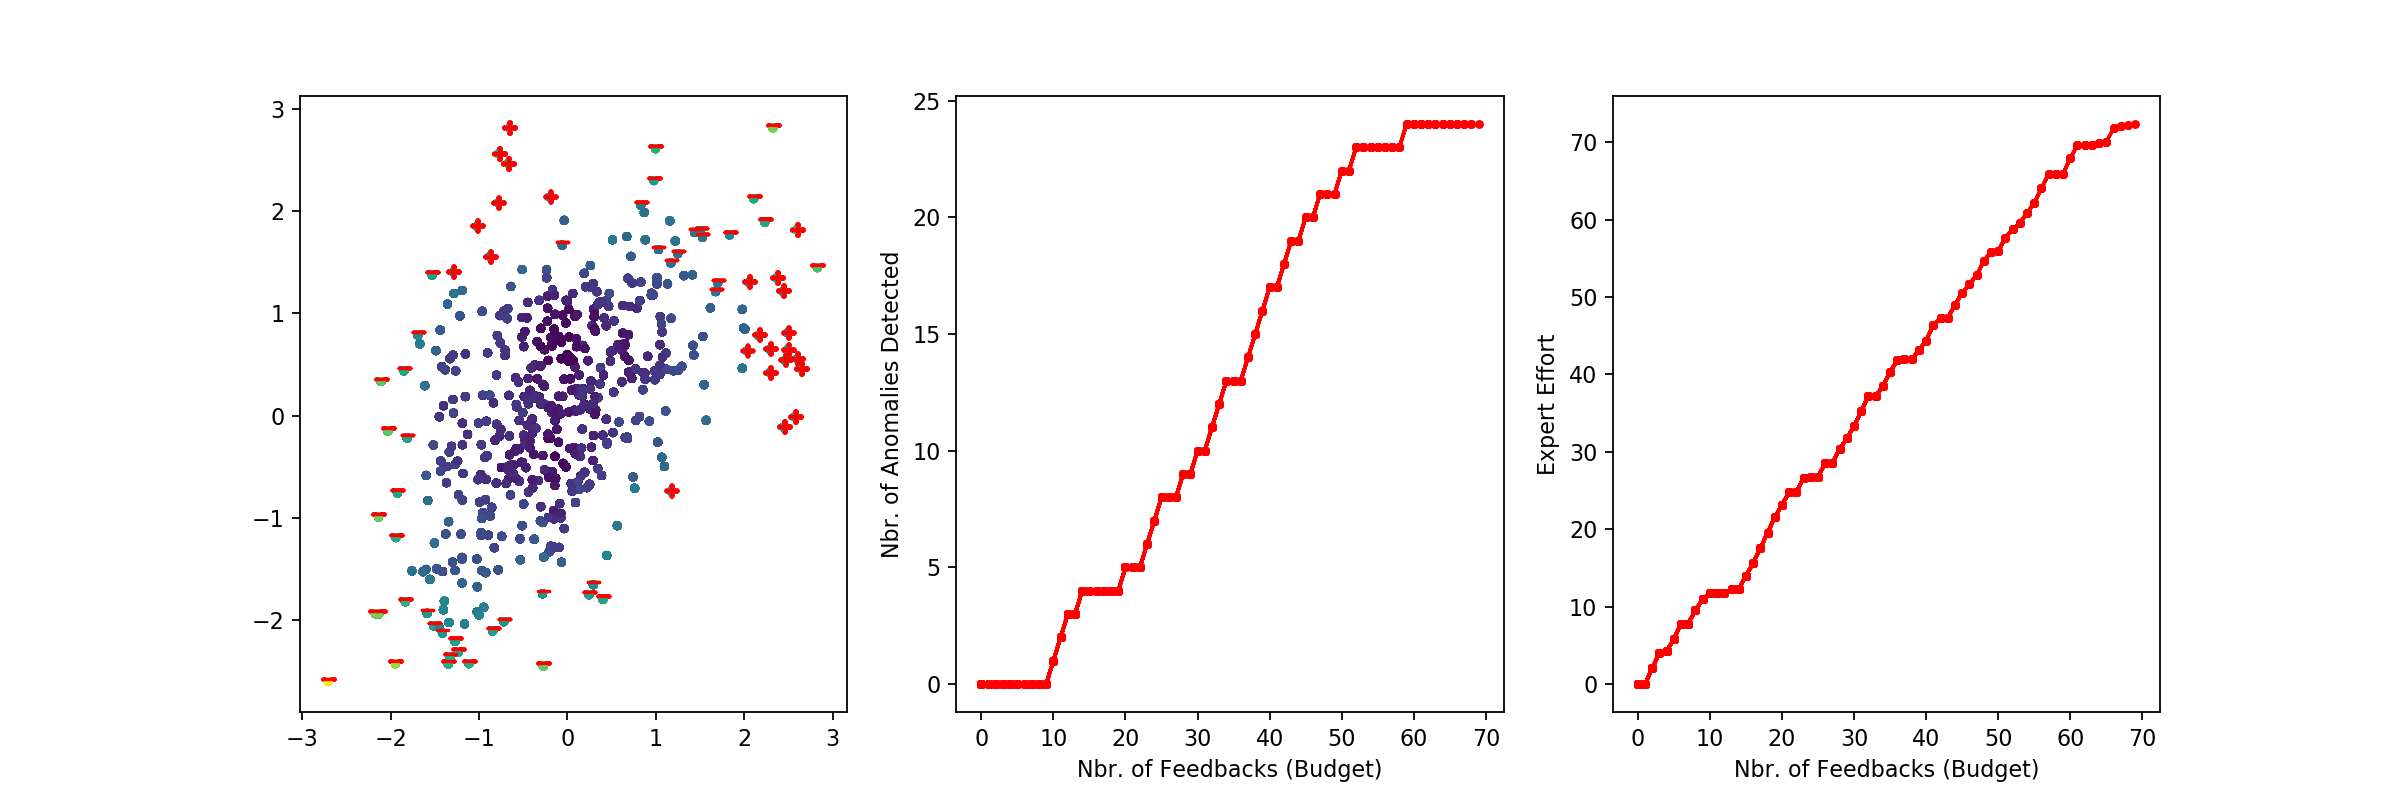

Total: 70 (24 anomalies, 46 nominals)

In [8]:
model = OMD(Z, X, plot=True)       # Instanciating a model
feedback_loop(model, y, budget=70)  # Using a a feedback loop that simulates an expert

using classifier to find relevant pattern in original data 

In [72]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

In [106]:
unique,counts = np.unique(y,return_counts=True) 
t=dict(zip(unique,counts))
t

{-1: 450, 1: 35}

In [113]:
clustering = DBSCAN(eps=0.1, min_samples=5).fit(X)

In [114]:
pseudo_label = - clustering.labels_

In [115]:
unique,counts = np.unique(pseudo_label,return_counts=True) 
t=dict(zip(unique,counts))
t

{-13: 5,
 -12: 5,
 -11: 5,
 -10: 7,
 -9: 8,
 -8: 9,
 -7: 9,
 -6: 8,
 -5: 10,
 -4: 6,
 -3: 6,
 -2: 9,
 -1: 20,
 0: 19,
 1: 359}

In [89]:
pseudo_labels=[]
for i in pseudo_label:
    if i == 0:
        pseudo_labels.append(-1) 
    else:
        i = 1
        pseudo_labels.append(1)

In [73]:
clf = RandomForestClassifier(n_estimators=100, random_state=1)

In [107]:
budget = 5
prob_fac=np.ones(y.shape)
for itr in range(budget):
    clf.fit(X, pseudo_labels).predict(X)
    proba = clf.predict_proba(X)
    i = np.argmax(prob_fac*proba[:,1]) # instance has highest probability of label=1
    feedback = y[i]       # present the selected instance to an expert and get a feedback
    if y[i] == 1:
        prob_fac[i] = -np.inf
    else:
        pseudo_labels[i] = -1
        prob_fac[i] = -np.inf
    
    #pseudo_label = w*pseudo_label  # update the label set


In [108]:
unique,counts = np.unique(pseudo_labels,return_counts=True) 
t=dict(zip(unique,counts))
t

{-1: 457, 1: 28}

<IPython.core.display.Javascript object>


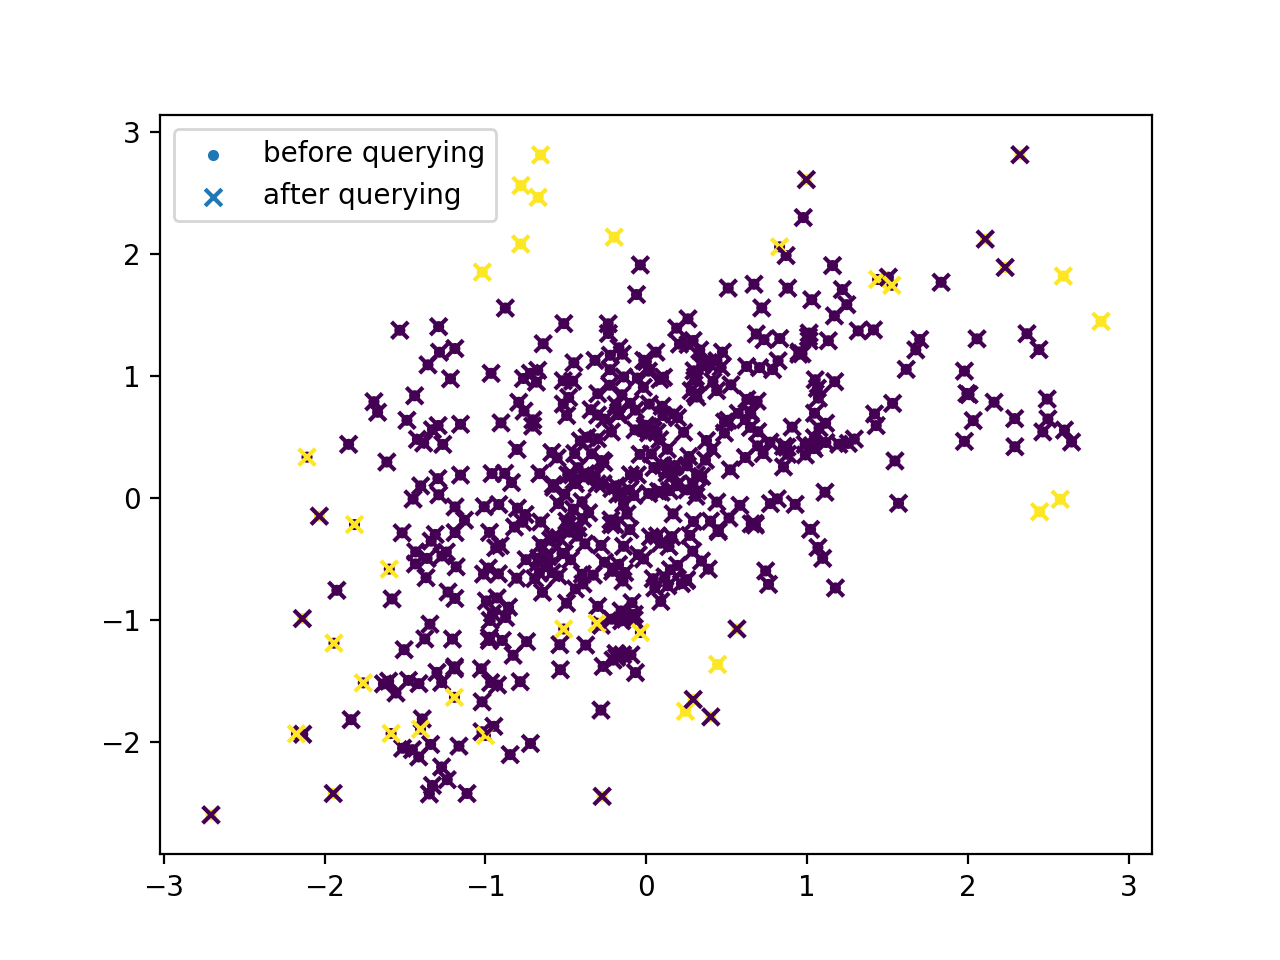

In [112]:
#fig, ax1 = plt.plot(figsize=(15, 5))
plt.scatter(X[:, 0], X[:, 1], marker=".", c=pseudo_label, label='before querying')

plt.scatter(X[:, 0], X[:, 1], marker="x", c=pseudo_labels,label='after querying')

plt.legend()



In [ ]:
My_pred = IsolationForest(contamination='auto',behaviour='deprecated').fit_predict(X)

In [ ]:
My_pred=pd.DataFrame(My_pred)
predict_label=np.array(My_pred.replace(np.unique(My_pred),[1,-1]))

# 3. Evaluation of different models


In [9]:
eva = Evaluation(y, expname="myExperiment")

for _ in range(2):
    Z = IsoForest().fit(X).transform(X)
    eva.run([Unsupervised(Z, X), OJRank(Z, X), OMD(Z, X)])


Total: 70 (27 anomalies, 43 nominals)

<IPython.core.display.Javascript object>


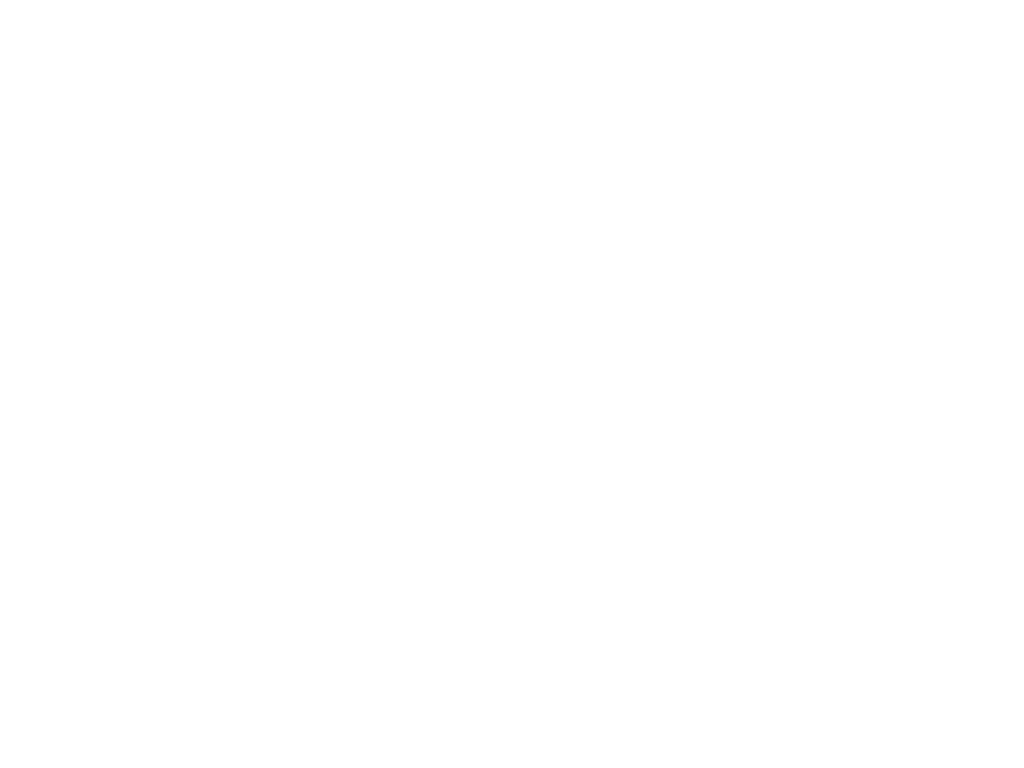

<IPython.core.display.Javascript object>


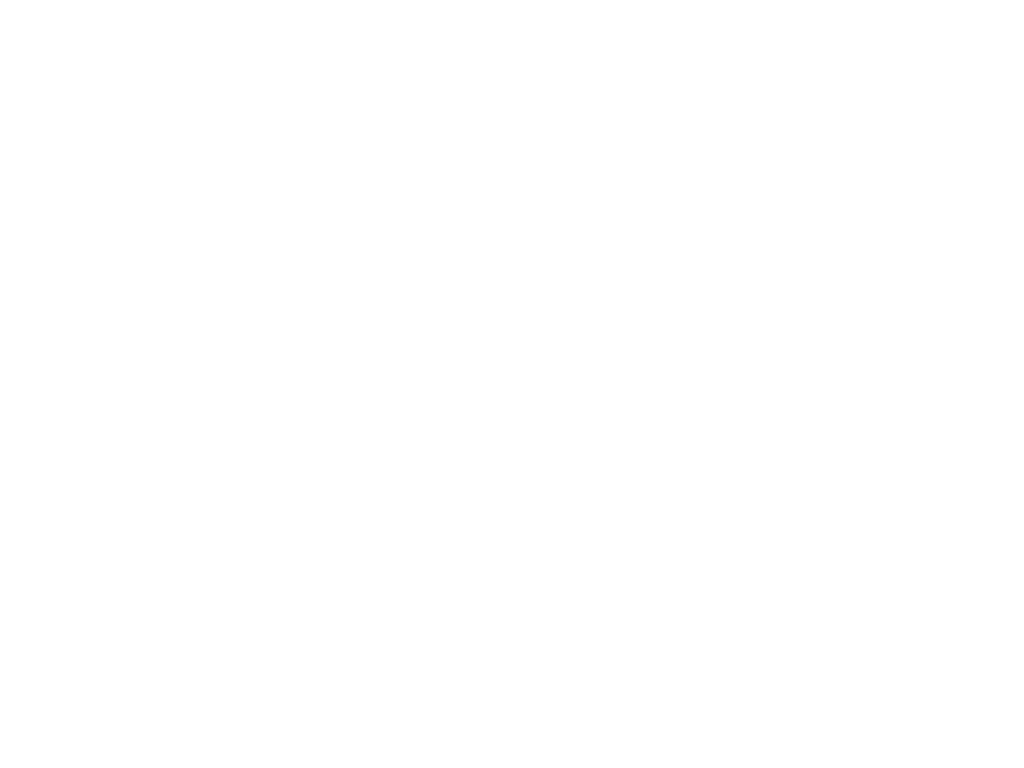

<IPython.core.display.Javascript object>


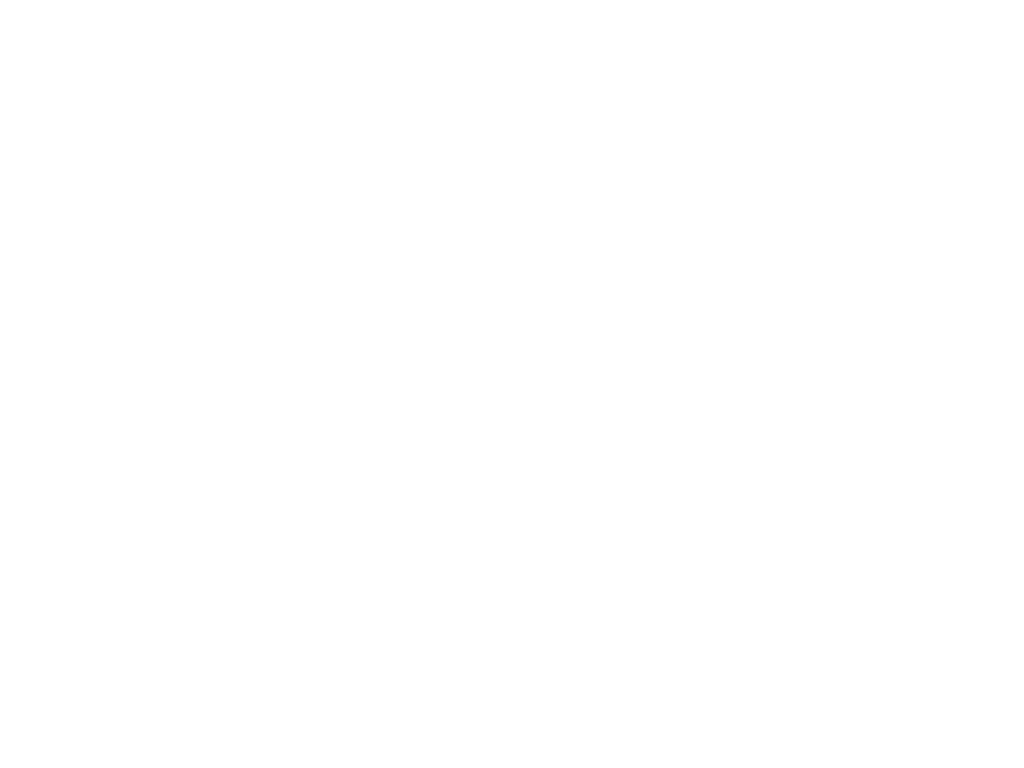

In [10]:
eva.plot_results("myExperiment.json", "precision")
eva.plot_results("myExperiment.json", "effort")